In [1]:
# Import the libraries

import pandas as pd 
import numpy as np

from pprint import pprint

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

import spacy

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.corpus import wordnet

import warnings
warnings.filterwarnings("ignore")


/Users/siriamanda/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/Users/siriamanda/opt/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]


Code references:

https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/


In [2]:
df = pd.read_csv('/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/sentiment-analysis-of-reviews/01-sentiment-analysis/04-tools-for-data/VADER-tools-for-data.csv')


In [3]:
df.head()

,Unnamed: 0,date,review,rating,status,length,label,language_scores,language,scores,compound,sentiment
0,0,2021-03-10,Some of the lab instructions are out of synch ...,3,completer,442,neu,"{'language': 'en', 'score': 0.999997056713954}",en,"{'neg': 0.075, 'neu': 0.895, 'pos': 0.029, 'co...",-0.3818,neg
1,1,2021-03-10,Very nice course.,5,completer,18,pos,"{'language': 'en', 'score': 0.9999965592297603}",en,"{'neg': 0.0, 'neu': 0.393, 'pos': 0.607, 'comp...",0.4754,pos
2,2,2021-03-10,I have learned much knowledge about data scien...,5,completer,210,pos,"{'language': 'en', 'score': 0.9999959027806586}",en,"{'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...",0.8923,pos
3,3,2021-03-08,Clear Idea about the Data Science and its tools,5,completer,47,pos,"{'language': 'en', 'score': 0.9999971743061971}",en,"{'neg': 0.0, 'neu': 0.755, 'pos': 0.245, 'comp...",0.3818,pos
4,4,2021-03-08,"Nice overview, though the course materials hav...",3,completer,450,neu,"{'language': 'en', 'score': 0.9999962557747355}",en,"{'neg': 0.055, 'neu': 0.873, 'pos': 0.072, 'co...",0.3400,pos


In [4]:
df.drop(['Unnamed: 0', 'language_scores', 'language', 'scores'], axis = 1, inplace = True)

In [5]:
df

,date,review,rating,status,length,label,compound,sentiment
0,2021-03-10,Some of the lab instructions are out of synch ...,3,completer,442,neu,-0.3818,neg
1,2021-03-10,Very nice course.,5,completer,18,pos,0.4754,pos
2,2021-03-10,I have learned much knowledge about data scien...,5,completer,210,pos,0.8923,pos
3,2021-03-08,Clear Idea about the Data Science and its tools,5,completer,47,pos,0.3818,pos
4,2021-03-08,"Nice overview, though the course materials hav...",3,completer,450,neu,0.3400,pos
...,...,...,...,...,...,...,...,...
3031,2018-09-19,Another Great class. Really introduces you to...,5,dropout,188,pos,0.8360,pos
3032,2018-09-19,Great introduction to the various open source ...,5,dropout,75,pos,0.6249,pos
3033,2018-09-19,Simple trivial materials,3,dropout,24,neu,-0.0258,neg
3034,2018-09-19,Very practical course!,5,dropout,22,pos,0.0000,neu


In [6]:
# Check for null values

len(df[df['review'].isna()==True])

0

In [7]:
# Drop null values

# df.dropna(inplace = True)

In [8]:
# Check for null values

# len(df[df['review'].isna()==True])

In [9]:
# Reset the index

# df = df.reset_index(drop = True)

In [10]:
# df

In [11]:
# Define a function to plot the most frequent words

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.xticks(rotation = 45)
    plt.show()

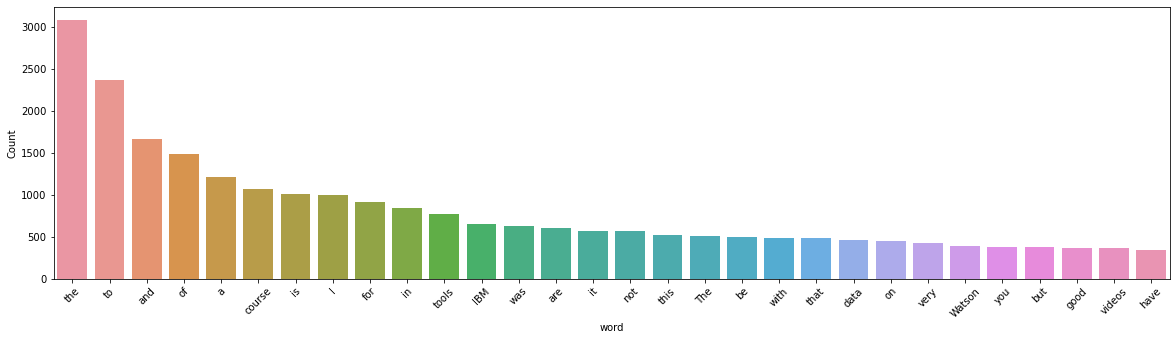

In [12]:
# The most frquent words are stop words such as 'to' and 'the' we will remove these in the preprocessing steps

freq_words(df['review'])

## Preprocessing

In [13]:
# Covert to lowercase

df['preprocessed'] =  df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['preprocessed'].head()

0    some of the lab instructions are out of synch ...
1                                    very nice course.
2    i have learned much knowledge about data scien...
3      clear idea about the data science and its tools
4    nice overview, though the course materials hav...
Name: preprocessed, dtype: object

In [14]:
# Remove punctuations

df['preprocessed'] = df['preprocessed'].str.replace('[^\w\s]','')
df['preprocessed'].head()

0    some of the lab instructions are out of synch ...
1                                     very nice course
2    i have learned much knowledge about data scien...
3      clear idea about the data science and its tools
4    nice overview though the course materials have...
Name: preprocessed, dtype: object

In [15]:
# Remove stopwords

stop = stopwords.words('english')
stop.extend(['good', 'great', 'really', 'like', 'nice', 'use', 'need'])

df['preprocessed'] = df['preprocessed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['preprocessed'].head()

0    lab instructions synch screenshots also extern...
1                                               course
2    learned much knowledge data science many tools...
3                        clear idea data science tools
4    overview though course materials updated detai...
Name: preprocessed, dtype: object

In [16]:
df[(df['preprocessed']== "")]

,date,review,rating,status,length,label,compound,sentiment,preprocessed
20,2021-02-26,good,4,completer,4,pos,0.4404,pos,
49,2021-02-08,good!,5,completer,5,pos,0.4926,pos,
110,2021-01-05,very nice,5,dropout,9,pos,0.4754,pos,
143,2020-12-17,Great,5,completer,5,pos,0.6249,pos,
152,2020-12-13,nice!,5,completer,5,pos,0.4753,pos,
...,...,...,...,...,...,...,...,...,...
2905,2018-12-08,vERY Good,5,completer,9,pos,0.4927,pos,
2908,2018-12-08,Nice,5,dropout,4,pos,0.4215,pos,
2928,2018-11-20,Great.,5,completer,6,pos,0.6249,pos,
2935,2018-11-18,great!!!,5,dropout,8,pos,0.7163,pos,


In [17]:
df = df[(df['preprocessed']!= "")]

In [18]:
# Reset the index

df = df.reset_index(drop = True)

In [19]:
# Remove short words (length < 3)

# df['review'] = df['review'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
# df['review'].head()

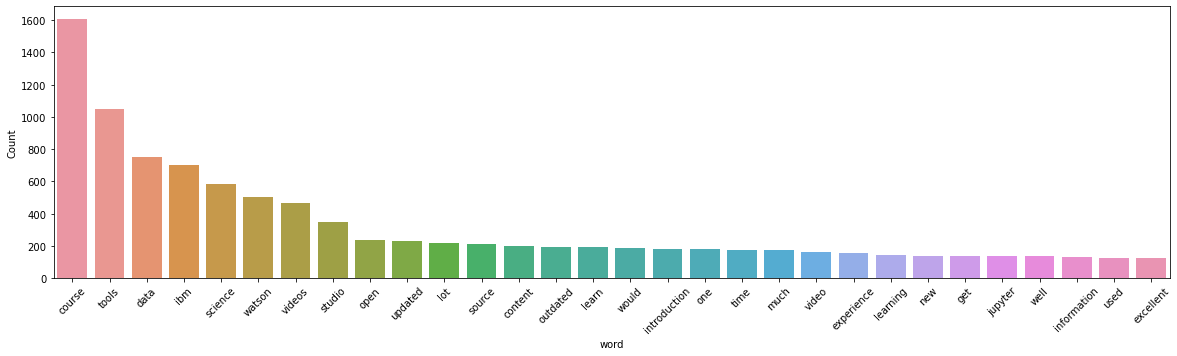

In [20]:
# Look at the most frequent words again 

freq_words(df['preprocessed'])

In [21]:
# Tokenization

tokenizer = RegexpTokenizer(r'\w+')

df['preprocessed'] = df['preprocessed'].apply(lambda x: tokenizer.tokenize(x.lower()))
df['preprocessed'].head(5)


0    [lab, instructions, synch, screenshots, also, ...
1                                             [course]
2    [learned, much, knowledge, data, science, many...
3                  [clear, idea, data, science, tools]
4    [overview, though, course, materials, updated,...
Name: preprocessed, dtype: object

In [22]:
# Add speech tags

df['preprocessed'] = df['preprocessed'].apply(nltk.tag.pos_tag)
df['preprocessed'].head()

0    [(lab, NN), (instructions, NNS), (synch, VBP),...
1                                       [(course, NN)]
2    [(learned, VBN), (much, JJ), (knowledge, NN), ...
3    [(clear, JJ), (idea, NN), (data, NNS), (scienc...
4    [(overview, NN), (though, IN), (course, NN), (...
Name: preprocessed, dtype: object

In [23]:
# Define function to convert parts of speech tags to wordnet’s format

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [24]:
# Apply the function to the tagged data

df['preprocessed'] = df['preprocessed'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
df['preprocessed'].head()

0    [(lab, n), (instructions, n), (synch, v), (scr...
1                                        [(course, n)]
2    [(learned, v), (much, a), (knowledge, n), (dat...
3    [(clear, a), (idea, n), (data, n), (science, n...
4    [(overview, n), (though, n), (course, n), (mat...
Name: preprocessed, dtype: object

In [25]:
df['preprocessed'][1]

[('course', 'n')]

In [26]:
# Create lemmatizer

lemmatizer = WordNetLemmatizer()

# Apply to data 

df['preprocessed'] = df['preprocessed'].apply(lambda x: [lemmatizer.lemmatize(word, tag) for word, tag in x])
df['preprocessed'].head()

0    [lab, instruction, synch, screenshots, also, e...
1                                             [course]
2    [learn, much, knowledge, data, science, many, ...
3                   [clear, idea, data, science, tool]
4    [overview, though, course, material, update, d...
Name: preprocessed, dtype: object

In [27]:
# Join reviews

df['joined'] = df['preprocessed'].apply(lambda x: ' '.join(x))

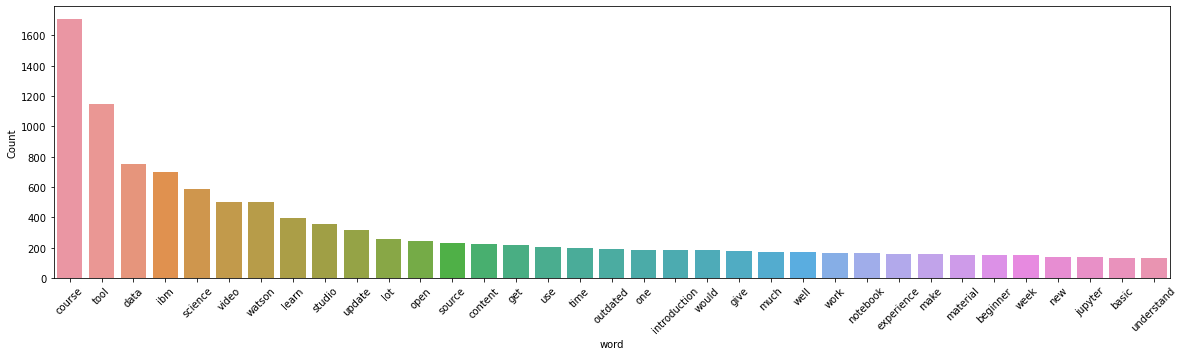

In [28]:
# Most frequent words after lemmatizing 

freq_words(df['joined'], 35)

## LDA Topic Modeling

In [29]:
# Create a dictionary from 'df_sen['review']' containing the number of times a word appears in the training set

dictionary = gensim.corpora.Dictionary(df['preprocessed'])

In [30]:
# Gensim filter extremes

# Filter out tokens that appear in:
# Less than 50 documents, more than 0.5 documents, and keep only 100000 most frquent tokens

# dictionary.filter_extremes(no_below = 50, no_above = 0.5, keep_n = 100000)

In [31]:
# Gensim doc2bow
# Create a dictionary reporting how many words and how many times those words appear

corpus = [dictionary.doc2bow(doc) for doc in df['preprocessed']]


In [32]:
# Add TF-IDF

tfidf = models.TfidfModel(corpus)      # Create a TF-IDF model
corpus_tfidf = tfidf[corpus]  

In [33]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.LdaMulticore

# Build LDA model
lda_model = LDA(corpus = corpus, id2word = dictionary, num_topics = 4, random_state = 100,
                chunksize = 100, passes = 10, alpha = 0.22)

In [34]:
# Explore the words occurring in each topic and its relative weight

for id, topic in lda_model.print_topics(-1):
    print('Topic: {}\nWord: {}\n'.format(id, topic))
    
print('Topic 0: Video material, Topic 1: Technologies, Topic 2: Content, Topic 3: Learning experience')

Topic: 0
Word: 0.080*"course" + 0.056*"tool" + 0.032*"data" + 0.029*"open" + 0.029*"source" + 0.025*"science" + 0.020*"learn" + 0.019*"introduction" + 0.017*"excellent" + 0.016*"ibm"

Topic: 1
Word: 0.039*"ibm" + 0.038*"watson" + 0.031*"course" + 0.029*"video" + 0.028*"studio" + 0.023*"update" + 0.018*"tool" + 0.010*"notebook" + 0.008*"version" + 0.008*"jupyter"

Topic: 2
Word: 0.057*"tool" + 0.051*"course" + 0.047*"data" + 0.039*"science" + 0.016*"learn" + 0.011*"give" + 0.011*"use" + 0.010*"overview" + 0.009*"lot" + 0.009*"available"

Topic: 3
Word: 0.035*"course" + 0.016*"video" + 0.015*"content" + 0.014*"outdated" + 0.012*"time" + 0.011*"week" + 0.010*"little" + 0.010*"follow" + 0.009*"bit" + 0.009*"much"

Topic 0: Video material, Topic 1: Technologies, Topic 2: Content, Topic 3: Learning experience


### Visualise with pyLDAvis

Original paper: https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [35]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.095931  0.125069       1        1  34.566981
2     -0.099837 -0.048055       2        1  27.335664
3      0.142234 -0.097835       3        1  21.874142
0     -0.138328  0.020821       4        1  16.223213, topic_info=           Term         Freq        Total Category  logprob  loglift
32         tool  1051.000000  1051.000000  Default  30.0000  30.0000
35         data   674.000000   674.000000  Default  29.0000  29.0000
46      science   528.000000   528.000000  Default  28.0000  28.0000
34       course  1514.000000  1514.000000  Default  27.0000  27.0000
151      watson   485.000000   485.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
258        easy    24.804028   115.161583   Topic4  -5.3902   0.2834
60     material    23.504888   142.312019   Topic4  -5.4440   0.0179
216  experience    22.823622   148.542567   Topic4  -5.4734  -0.0543
288        make    22.353928   142.057843   Topic4  -5.4942  -0.0305
152     content    22.353609   213.634058   Topic4  -5.4942  -0.4385

[305 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1269      1  0.909097    accord
709       1  0.894223   account
709       2  0.103979   account
650       4  0.703156  acquaint
865       1  0.852079    actual
...     ...       ...       ...
2511      3  0.934422   wouldnt
2164      1  0.891515  zeppelin
2164      2  0.015371  zeppelin
2164      4  0.092226  zeppelin
1736      3  0.954922         ã

[547 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

What is topic perplexity and topic coherence: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [36]:
# Calculate Perplexity and Coherence

# Compute Perplexity

print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. The lower the better.

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model = lda_model, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.718774475313731

Coherence Score:  0.4482907065910259


## Hyperparameter Tuning

Code references

Find the optimal number of topics, alpha and beta: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

What is alpha and beta: https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/

## Calculate the coherence score

Code reference: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [37]:
# Determine the optiomal number of topics by calculating the coherence score

# Define function for calculating coherence score

def compute_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LDA(corpus = corpus, num_topics = num_topics, id2word = dictionary, random_state = 100,
                chunksize = 100, passes = 10, alpha = 0.18)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [38]:
# Can take a long time to run.

model_list, coherence_values = compute_coherence_values(dictionary = dictionary, corpus = corpus, texts = df['preprocessed'], start = 2, limit = 10, step = 1)

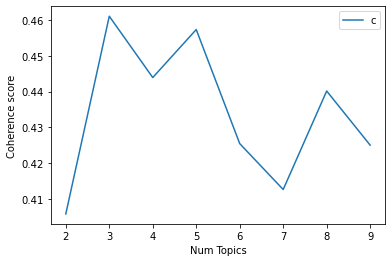

In [39]:
# Show graph

limit = 10; start = 2; step = 1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()


In [40]:
# Print the coherence scores

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4058
Num Topics = 3  has Coherence Value of 0.461
Num Topics = 4  has Coherence Value of 0.4439
Num Topics = 5  has Coherence Value of 0.4573
Num Topics = 6  has Coherence Value of 0.4255
Num Topics = 7  has Coherence Value of 0.4126
Num Topics = 8  has Coherence Value of 0.4401
Num Topics = 9  has Coherence Value of 0.425


## LDA Mallet Model

Code reference:

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

In [84]:
mallet_path = '/Users/siriamanda/Desktop/LNU-VT-2021/Thesis/11-data-analysis/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = 5, id2word = dictionary)

In [85]:
# Show Topics
pprint(ldamallet.show_topics(formatted = False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model = ldamallet, texts = df['preprocessed'], dictionary = dictionary, coherence = 'c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

# The coherence score using the Mallet Model is lower than the original LDA Model

[(0,
  [('ibm', 0.13843423387891934),
   ('watson', 0.09879708144350227),
   ('studio', 0.0700059159929008),
   ('update', 0.06211792545848945),
   ('notebook', 0.03332676000788799),
   ('content', 0.027213567343719186),
   ('jupyter', 0.02681916781699862),
   ('cloud', 0.020705975152829816),
   ('version', 0.019128377045947546),
   ('tutorial', 0.01833957799250641)]),
 (1,
  [('video', 0.0997229916897507),
   ('lot', 0.05065294815987337),
   ('time', 0.03957261574990107),
   ('outdated', 0.037989711119905026),
   ('experience', 0.031658092599920855),
   ('material', 0.030273051048674317),
   ('instruction', 0.024139295607439652),
   ('videos', 0.023545706371191136),
   ('follow', 0.02334784329244163),
   ('find', 0.01820340324495449)]),
 (2,
  [('give', 0.03394406943105111),
   ('make', 0.030665380906460944),
   ('week', 0.02892960462873674),
   ('easy', 0.021986499517839923),
   ('assignment', 0.020829315332690453),
   ('platform', 0.02063645130183221),
   ('start', 0.019093539054966

In [230]:
# Create new column with the topic

df['topic'] = ''

df['topic'] = [max(p, key = lambda item: item[1]) for p in lda_model[corpus]]

In [231]:
# Create two separate columns for the topic ID and topic score

df[['topic_id', 'topic_score']] = df['topic'].apply(pd.Series)

In [232]:
df

,date,review,rating,status,length,label,compound,sentiment,preprocessed,joined,topic,topic_id,topic_score
0,2021-03-10,Some of the lab instructions are out of synch ...,3,completer,442,neu,-0.3818,neg,"[lab, instruction, synch, screenshots, also, e...",lab instruction synch screenshots also externa...,"(0, 0.6499194)",0.0,0.649919
1,2021-03-10,Very nice course.,5,completer,18,pos,0.4754,pos,[course],course,"(0, 0.627182)",0.0,0.627182
2,2021-03-10,I have learned much knowledge about data scien...,5,completer,210,pos,0.8923,pos,"[learn, much, knowledge, data, science, many, ...",learn much knowledge data science many tool pr...,"(3, 0.96213746)",3.0,0.962137
3,2021-03-08,Clear Idea about the Data Science and its tools,5,completer,47,pos,0.3818,pos,"[clear, idea, data, science, tool]",clear idea data science tool,"(3, 0.88520813)",3.0,0.885208
4,2021-03-08,"Nice overview, though the course materials hav...",3,completer,450,neu,0.3400,pos,"[overview, though, course, material, update, d...",overview though course material update detaile...,"(3, 0.34690684)",3.0,0.346907
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,2018-09-19,Another Great class. Really introduces you to...,5,dropout,188,pos,0.8360,pos,"[another, class, introduce, new, tool, data, s...",another class introduce new tool data scientis...,"(1, 0.96028733)",1.0,0.960287
2934,2018-09-19,Great introduction to the various open source ...,5,dropout,75,pos,0.6249,pos,"[introduction, various, open, source, tool, us...",introduction various open source tool use data...,"(1, 0.9244344)",1.0,0.924434
2935,2018-09-19,Simple trivial materials,3,dropout,24,neu,-0.0258,neg,"[simple, trivial, material]",simple trivial material,"(1, 0.5629533)",1.0,0.562953
2936,2018-09-19,Very practical course!,5,dropout,22,pos,0.0000,neu,"[practical, course]",practical course,"(3, 0.76551014)",3.0,0.765510


In [233]:
df_final = df.drop(['joined', 'topic'], axis = 1)

In [234]:
# Save dataframe as a csv file

df_final.to_csv('tools-for-data.csv')